# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [42]:
import pickle
import umap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from umap import UMAP
from pyentrp import entropy as ent
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

## Load ELAsTiCC data set

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [3]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

## Loop through and compute the entropies

In [19]:
df_arr = []
class_arr = []

for i in range(len(astrophysical_classes)):

    # Find the detections
    phot_flag = X_ts[i]['detection_flag']
    idx = np.where(phot_flag==1)[0]

    # Find the time series and rescale
    time = X_ts[i]['scaled_time_since_first_obs'].to_numpy()[idx] * 100
    time = time - min(time)
    
    flux = X_ts[i]['scaled_FLUXCAL'].to_numpy()[idx] * 1000
    mean_wavelength = X_ts[i]['band_label'].to_numpy()[idx] * 10000 # in angstrom

    if len(idx) > 30 and np.all(flux > 0):

        # Convert from flux to mags
        mag = 27.5 - 2.5 * np.log10(flux)

        df = pd.DataFrame()
        df['mag'] = mag
        df['time'] = time
        df['wavelength'] = mean_wavelength
        
        df_arr.append(df)
        class_arr.append(astrophysical_classes[i])


In [20]:
df_arr

[          mag     time  wavelength
 0   24.570919   0.0000      6215.0
 1   22.905731   4.1788      6215.0
 2   22.940205   4.2030      7545.0
 3   22.527876   6.1363      6215.0
 4   22.634151   6.1377      6215.0
 5   22.682045   6.1605      7545.0
 6   22.685411   6.1619      7545.0
 7   22.243290  12.1824      8700.0
 8   22.168884  12.1829      8700.0
 9   22.184782  12.2066     10150.0
 10  22.231398  16.1295      8700.0
 11  22.366833  16.1460      8700.0
 12  22.327824  18.1486     10150.0
 13  22.211285  20.1172      7545.0
 14  22.127615  21.0855      8700.0
 15  22.372284  21.1097      7545.0
 16  22.340305  22.0885      8700.0
 17  22.292564  22.0899      8700.0
 18  22.281384  22.1125      7545.0
 19  22.254608  22.1138      7545.0
 20  22.603027  23.0800      6215.0
 21  22.619755  23.0805      6215.0
 22  22.455883  23.1041      7545.0
 23  22.168453  23.1046      7545.0
 24  23.256805  24.0453      4760.0
 25  22.579498  24.0700      6215.0
 26  23.599590  31.1011     

In [168]:
def plot_lc_with_GP_fit(k):
    divider = 1000

    df = df_arr[k]
    X = np.array([df['time'], df['wavelength'].to_numpy()/divider]).T
    Y = df['mag']
    df_class = class_arr[k]

    kernel = Matern(length_scale=2, nu=0.2)
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=42)
    gpr.fit(X, Y)

    # Plot the original lc and the interpolated lc
    for i, band_wavelength in enumerate(np.unique(df['wavelength'])):

        # Separate by passband
        band_idx = np.where(df['wavelength'].to_numpy() == band_wavelength)[0]
    
        # Find GP fit
        time_array = np.arange(0, max(df['time']) + 1, 1)
        wavelength_array = np.array([float(band_wavelength)] * len(time_array))
        interp_mag_mean, interp_mag_std  = gpr.predict(np.array([time_array, wavelength_array/divider]).T, return_std=True)
    
        offset = i
    
        # Scatter true points
        plt.scatter(df['time'][band_idx], df['mag'][band_idx] + offset, color=f'C{i}', marker='.', label=f'{band_wavelength:.0f}A')
    
        # Plot the GP predicitons
        plt.plot(time_array, interp_mag_mean + offset, color=f'C{i}')
        plt.fill_between(time_array, interp_mag_mean + offset - interp_mag_std, interp_mag_mean + offset + interp_mag_std, alpha=0.1, color=f'C{i}')
        
    
    plt.xlabel("Time")
    plt.ylabel("magnitude + offset")
    plt.gca().invert_yaxis()
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"{df_class} | Index: {k}")
    
    plt.show()

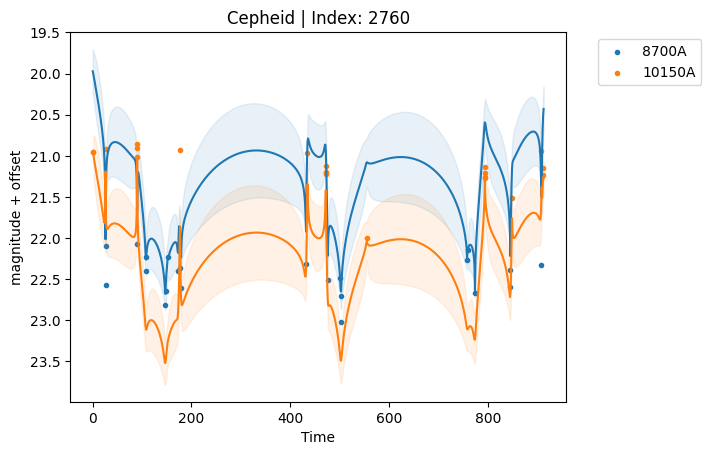

In [169]:
plot_lc_with_GP_fit(2760)

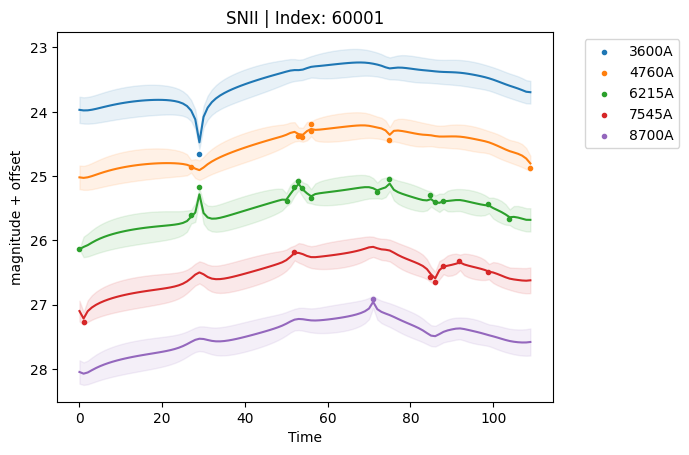

In [171]:
plot_lc_with_GP_fit(60001)

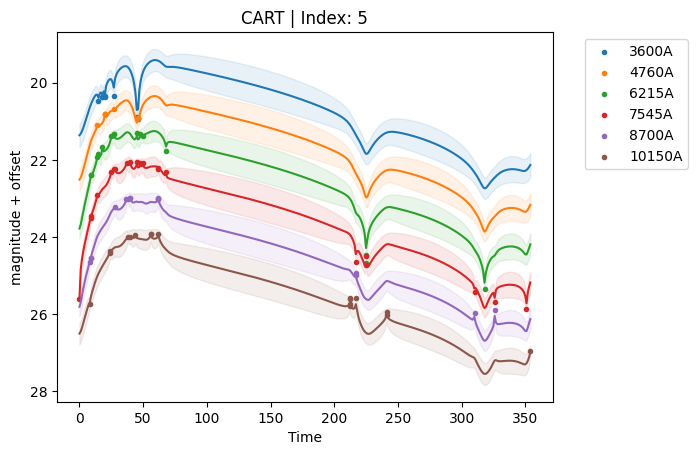

In [172]:
plot_lc_with_GP_fit(5)